In [293]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")
class STF:

    # init method or constructor 
    def __init__(self, data, window, cutoff, period):
        self.data = data
        self.window = window
        self.cutoff = cutoff
        self.period = period
        self._observed = data

    def fit(self):
        
        dt = 1 / self.period
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        #print(f[-1])
        half = np.floor(len(t)/2)
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        self.observed = pd.Series(self.data.squeeze(), self.data.index)
      

        n = len(reflected)
        #Compute FFT
        fhat = np.fft.fft(reflected, n)
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(reflected))
        else:
            window = get_window(self.window, len(reflected))

        PSD = PSD*window
      
    
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')


        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, self.cutoff))
        print(np.quantile(PSD, self.cutoff))
        indices = PSD < peaks
        #indices = indices[int(half):(n + int(half))]
   
        # Zero out small Fourier coefs
        fhat_clean = indices * fhat
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat_clean)

        # Filter out freqs with high power
        indices_seasonal = PSD >= peaks
        fhat_seasonal = indices_seasonal * fhat
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)

        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

(4.500158305023342+0j)
The dot product of STF seasonal and trend components is  (83-0j)


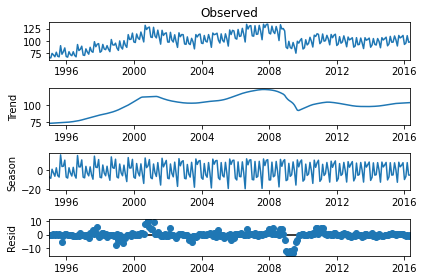

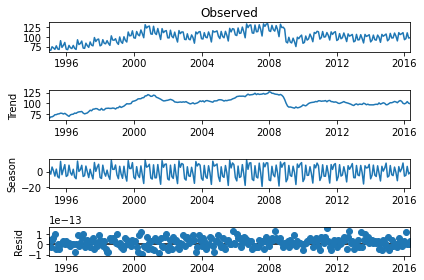

In [302]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds

#TODO: 3/23/2022
# Append one row to make an even array
# Double the length and pad with zeros 

# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
stf = STF(elec_equip, "blackman", .8, period = 12)
res = stf.fit()
fig = res.plot()
#This has an odd length, could possibly be causing the tails to be 

(4.671087380414097+0j)
The dot product of STF seasonal and trend components is  (-13+0j)


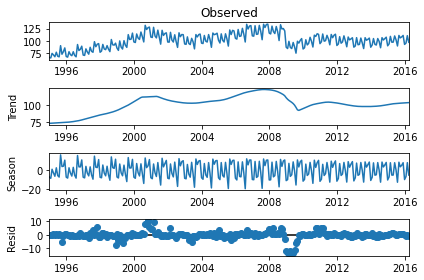

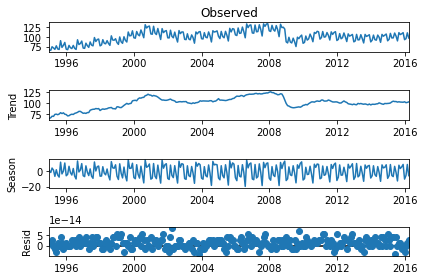

In [316]:
# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
elec_equip = elec_equip[0:256]
stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
stf = STF(elec_equip, "blackman", .8, period = 12)
res = stf.fit()
fig = res.plot()

348
(26.71065453312737+0j)
The dot product of STF seasonal and trend components is  (176-0j)
(8.69063602804452+0j)
The dot product of STF seasonal and trend components is  (176-0j)
(94.11305440837985+0j)
The dot product of STF seasonal and trend components is  (201-0j)


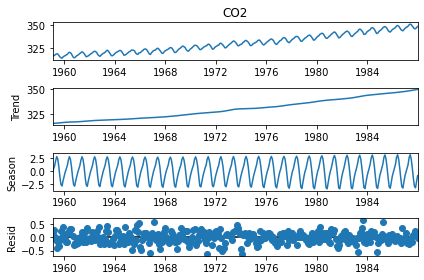

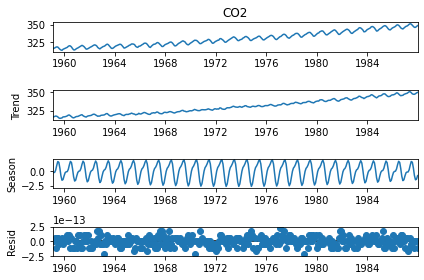

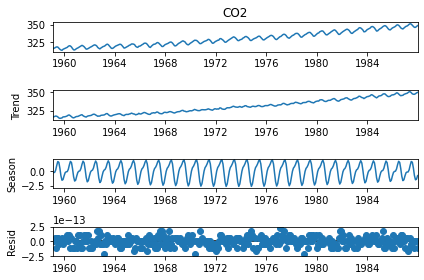

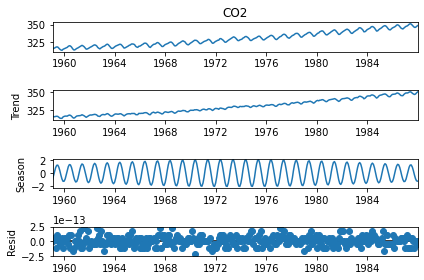

In [330]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()


stf = STF(co2, "hanning", .9955, period = 365)
res = stf.fit()
fig = res.plot()

stf = STF(co2, "blackman", .993, period = 365)
res = stf.fit()
fig = res.plot()

stf = STF(co2, "tukey", .995, period = 365)
res = stf.fit()
fig = res.plot()

(20407.692619096546+0j)
The dot product of STF seasonal and trend components is  (-336024258-4325778j)


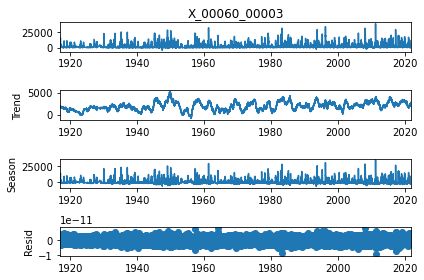

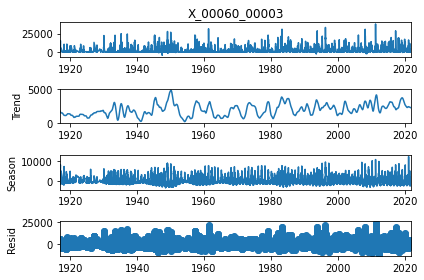

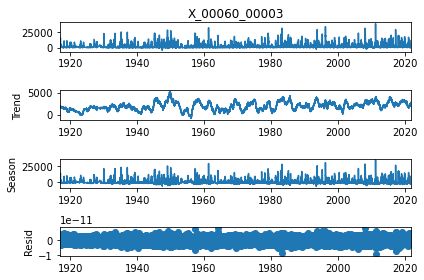

In [314]:
streamflow = pd.read_csv('../data/big_muddy_streamflow.csv', index_col='Date', parse_dates=True, squeeze=True)
stl = STL(streamflow["X_00060_00003"], period = 365)
res = stl.fit()
fig = res.plot()

streamflow = streamflow.fillna(0)
stf = STF(streamflow["X_00060_00003"], "tukey", 0.4, period = 365)
res = stf.fit()
res.plot()